In [2]:
import pandas as pd
import glob
import os
all_xray_df = pd.read_csv('./myApp/Documentation/Data_Entry_2017_v2020.csv')
all_image_paths = {os.path.basename(x): x for x in
                   glob.glob(os.path.join('.', 'images', 'images', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 0 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],path
71081,00017524_038.png,Nodule,38,17524,49,F,PA,2786,2613,0.143,0.143,None
19455,00005168_000.png,Atelectasis,0,5168,68,M,PA,2992,2991,0.143,0.143,None
80794,00019860_000.png,No Finding,12,19860,54,M,PA,2992,2991,0.143,0.143,None


In [3]:
from itertools import chain
import numpy as np
all_xray_df['Finding Labels'] = all_xray_df['Finding Labels'].map(lambda x: x.replace('No Finding', ''))
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
all_xray_df.sample(3)
all_labels


All Labels (14): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


['Atelectasis',
 'Cardiomegaly',
 'Consolidation',
 'Edema',
 'Effusion',
 'Emphysema',
 'Fibrosis',
 'Hernia',
 'Infiltration',
 'Mass',
 'Nodule',
 'Pleural_Thickening',
 'Pneumonia',
 'Pneumothorax']

In [4]:
# keep at least 1000 cases
MIN_CASES = 1000
all_labels = [c_label for c_label in all_labels if all_xray_df[c_label].sum()>MIN_CASES]
print('Clean Labels ({})'.format(len(all_labels)),
      [(c_label,int(all_xray_df[c_label].sum())) for c_label in all_labels])

Clean Labels (13) [('Atelectasis', 11559), ('Cardiomegaly', 2776), ('Consolidation', 4667), ('Edema', 2303), ('Effusion', 13317), ('Emphysema', 2516), ('Fibrosis', 1686), ('Infiltration', 19894), ('Mass', 5782), ('Nodule', 6331), ('Pleural_Thickening', 3385), ('Pneumonia', 1431), ('Pneumothorax', 5302)]


In [5]:
all_xray_df['disease_vec'] = all_xray_df.apply(lambda x: [x[all_labels].values], 1).map(lambda x: x[0])

In [6]:
from sklearn.model_selection import train_test_split
train_df, valid_df = train_test_split(all_xray_df,
                                   test_size = 0.25,
                                   random_state = 2018,
                                   stratify = all_xray_df['Finding Labels'].map(lambda x: x[:4]))
print('train', train_df.shape[0], 'validation', valid_df.shape[0])


train 84090 validation 28030


In [7]:
valid_df['newLabel'] = valid_df.apply(lambda x: x['Finding Labels'].split('|'), axis=1)
train_df['newLabel'] = train_df.apply(lambda x: x['Finding Labels'].split('|'), axis=1)


In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
IMG_SIZE = (128, 128)
core_idg = ImageDataGenerator(samplewise_center=True,
                              samplewise_std_normalization=True,
                              horizontal_flip = True,
                              vertical_flip = False,
                              height_shift_range= 0.05,
                              width_shift_range=0.1,
                              rotation_range=5,
                              shear_range = 0.1,
                              fill_mode = 'reflect',
                              zoom_range=0.15)


ModuleNotFoundError: No module named 'tensorflow'

In [19]:
!pip install -U pip tensorflow keras

  Obtaining dependency information for pip from https://files.pythonhosted.org/packages/8a/6a/19e9fe04fca059ccf770861c7d5721ab4c2aebc539889e97c7977528a53b/pip-24.0-py3-none-any.whl.metadata
  Obtaining dependency information for tensorflow from https://files.pythonhosted.org/packages/f9/14/67e9b2b2379cb530c0412123a674d045eca387dfcfa7db1c0028857b0a66/tensorflow-2.16.1-cp311-cp311-macosx_12_0_arm64.whl.metadata
  Obtaining dependency information for keras from https://files.pythonhosted.org/packages/54/b4/9b454f5264ada7c30c889d87b454466fd9ca28cb1bb271dedab2335f946a/keras-3.3.2-py3-none-any.whl.metadata
  Obtaining dependency information for ml-dtypes~=0.3.1 from https://files.pythonhosted.org/packages/6e/a4/6aabb78f1569550fd77c74d2c1d008b502c8ce72776bd88b14ea6c182c9e/ml_dtypes-0.3.2-cp311-cp311-macosx_10_9_universal2.whl.metadata
  Obtaining dependency information for tensorboard<2.17,>=2.16 from https://files.pythonhosted.org/packages/3a/d0/b97889ffa769e2d1fdebb632084d5e8b53fc299d43a537

In [13]:
train_gen = core_idg.flow_from_dataframe(dataframe=train_df,
                             directory=None,
                             x_col = 'path',
                            y_col = 'newLabel',
                             class_mode = 'categorical',
                            classes = all_labels,
                            target_size = IMG_SIZE,
                             color_mode = 'grayscale',
                            batch_size = 32)
valid_gen = core_idg.flow_from_dataframe(dataframe=valid_df,
                             directory=None,
                             x_col = 'path',
                            y_col = 'newLabel',
                             class_mode = 'categorical',
                            classes = all_labels,
                            target_size = IMG_SIZE,
                             color_mode = 'grayscale',
                            batch_size = 256) # we can use much larger batches for evaluation
test_X, test_Y = next(core_idg.flow_from_dataframe(dataframe=valid_df,
                             directory=None,
                             x_col = 'path',
                            y_col = 'newLabel',
                             class_mode = 'categorical',
                            classes = all_labels,
                            target_size = IMG_SIZE,
                             color_mode = 'grayscale',
                            batch_size = 1024))


NameError: name 'core_idg' is not defined

In [ ]:
import matplotlib.pyplot as plt
t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone', vmin = -1.5, vmax = 1.5)
    c_ax.set_title(', '.join([n_class for n_class, n_score in zip(all_labels, c_y)
                             if n_score>0.5]))
    c_ax.axis('off')


In [ ]:
from keras.applications.mobilenet import MobileNet
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from keras.models import Sequential
from keras import optimizers, callbacks, regularizers
base_mobilenet_model = MobileNet(input_shape =  t_x.shape[1:],
                                 include_top = False, weights = None)
multi_disease_model = Sequential()
multi_disease_model.add(base_mobilenet_model)
multi_disease_model.add(GlobalAveragePooling2D())
multi_disease_model.add(Dropout(0.5))
multi_disease_model.add(Dense(512))
multi_disease_model.add(Dropout(0.5))
multi_disease_model.add(Dense(len(all_labels), activation = 'sigmoid'))
multi_disease_model.compile(optimizer = 'adam', loss = 'binary_crossentropy',
                           metrics = ['binary_accuracy', 'mae'])
multi_disease_model.summary()

In [17]:
multi_disease_model.load_weights('myApp/models/xray_class_best_.weights.h5')
multi_disease_model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['binary_accuracy', 'mae'])
multi_disease_model.fit_generator(train_gen,
                                    validation_data = (test_X, test_Y),
                                    epochs = 1,
                                    callbacks = [callbacks.ModelCheckpoint('myApp/models/xray_class_best_.weights.h5',
                                                                         save_best_only = True)]
                                     )

C:\Users\yanni\AppData\Local\Temp\ipykernel_5528\1809211696.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  multi_disease_model.fit_generator(train_gen,


1211/1211 [==============================] - 602s 494ms/step - loss: 0.3296 - binary_accuracy: 0.8776 - mae: 0.1910 - val_loss: 0.3196 - val_binary_accuracy: 0.8789 - val_mae: 0.1758


c:\Users\yanni\Desktop\Travail de Bachelor\mybachelorthesiswork\env\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [18]:
pred_Y = multi_disease_model.predict(test_X, batch_size = 32, verbose = True)
# look at how often the algorithm predicts certain diagnoses
for c_label, p_count, t_count in zip(all_labels,
                                     100*np.mean(pred_Y,0),
                                     100*np.mean(test_Y,0)):
    print('%s: Dx: %2.2f%%, PDx: %2.2f%%' % (c_label, t_count, p_count))


32/32 [==============================] - 3s 95ms/step
Atelectasis: Dx: 21.88%, PDx: 14.75%
Cardiomegaly: Dx: 3.32%, PDx: 3.85%
Consolidation: Dx: 9.57%, PDx: 12.22%
Edema: Dx: 4.10%, PDx: 5.57%
Effusion: Dx: 27.54%, PDx: 27.81%
Emphysema: Dx: 4.59%, PDx: 2.85%
Fibrosis: Dx: 3.71%, PDx: 1.71%
Infiltration: Dx: 39.94%, PDx: 40.71%
Mass: Dx: 12.01%, PDx: 7.32%
Nodule: Dx: 12.50%, PDx: 7.24%
Pleural_Thickening: Dx: 6.05%, PDx: 5.93%
Pneumonia: Dx: 2.25%, PDx: 1.92%
Pneumothorax: Dx: 10.94%, PDx: 7.07%


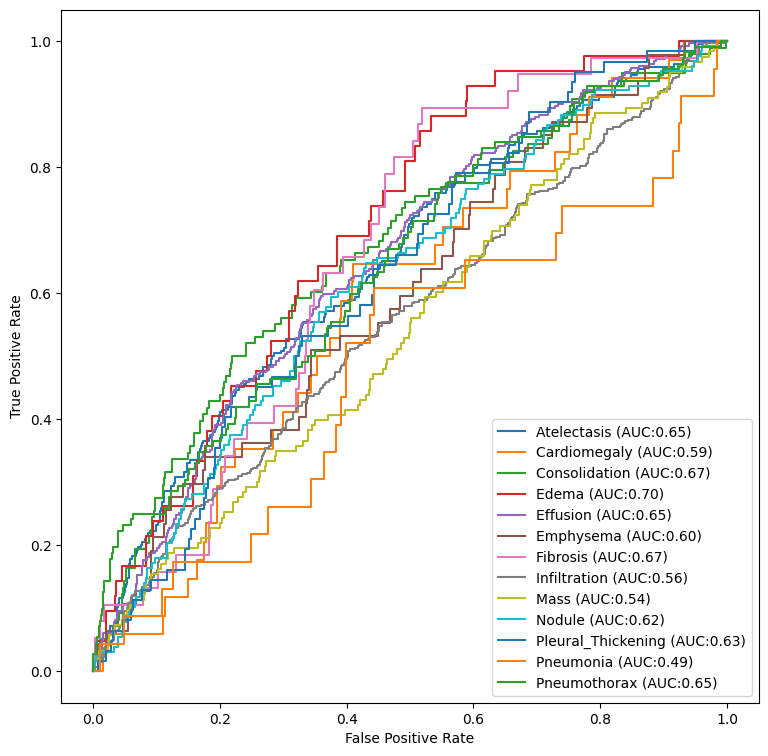

In [19]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(all_labels):
    fpr, tpr, thresholds = roc_curve(test_Y[:,idx].astype(int), pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig('trained_net.png')


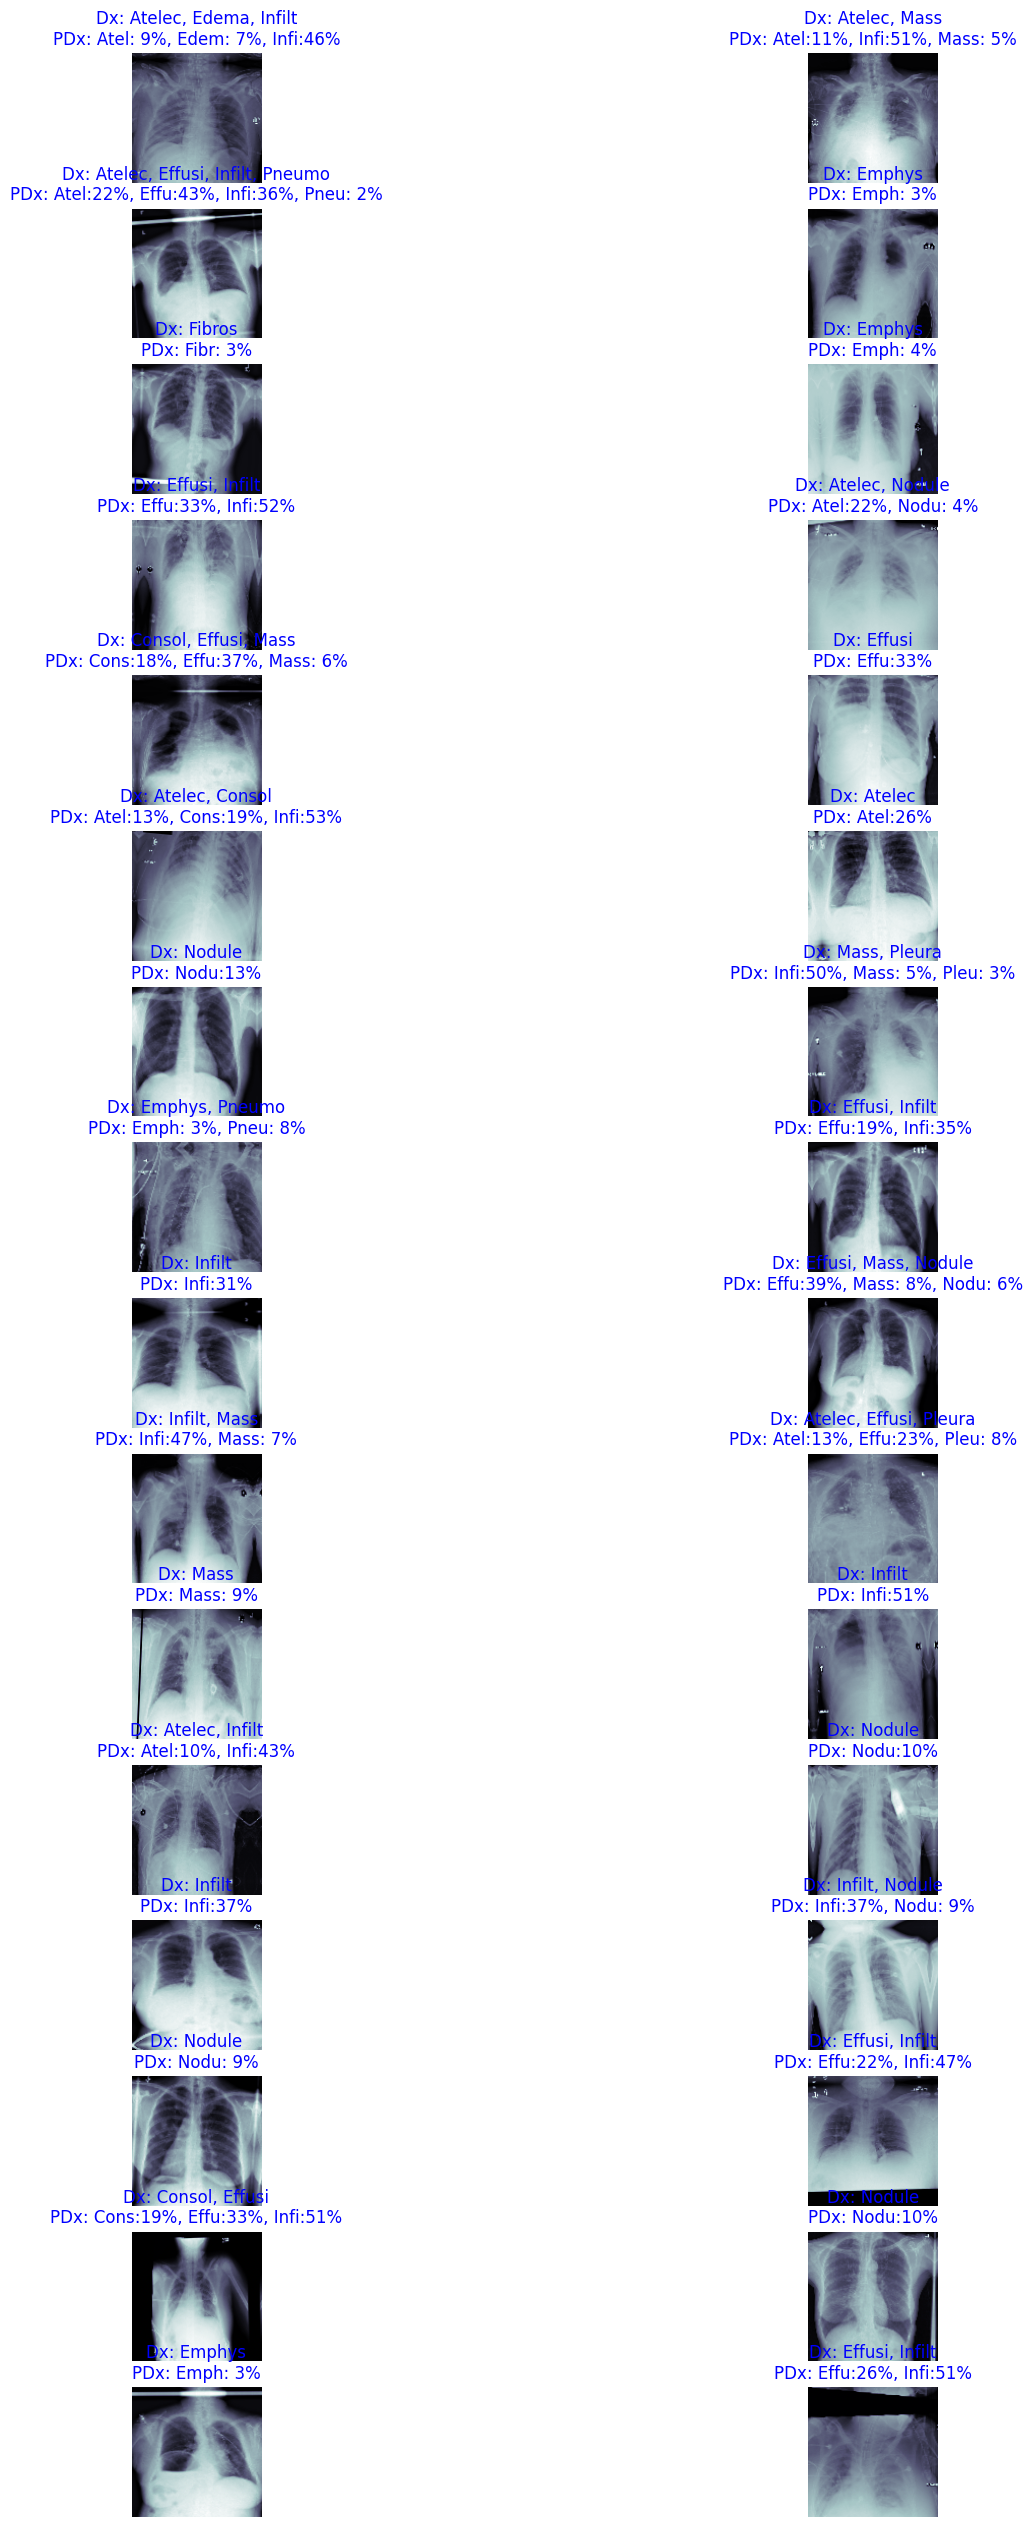

In [20]:
sickest_idx = np.argsort(np.sum(test_Y, 1)<1)
fig, m_axs = plt.subplots(16, 2, figsize = (16, 32))
for (idx, c_ax) in zip(sickest_idx, m_axs.flatten()):
    c_ax.imshow(test_X[idx, :,:,0], cmap = 'bone')
    stat_str = [n_class[:6] for n_class, n_score in zip(all_labels,
                                                                  test_Y[idx])
                             if n_score>0.5]
    pred_str = ['%s:%2.0f%%' % (n_class[:4], p_score*100)  for n_class, n_score, p_score in zip(all_labels,
                                                                  test_Y[idx], pred_Y[idx])
                             if (n_score>0.5) or (p_score>0.5)]
    c_ax.set_title('Dx: '+', '.join(stat_str)+'\nPDx: '+', '.join(pred_str), color='blue')
    c_ax.axis('off')
fig.savefig('trained_img_predictions.png')


In [25]:
from keras.callbacks import EarlyStopping
early = EarlyStopping(monitor="val_loss",
                      mode="min",
                      patience=5)
callbacks_list = [early]
multi_disease_model.fit(train_gen,
                        validation_data=(test_X, test_Y),
                        epochs=50,
                        callbacks= callbacks_list)

Epoch 1/50
1211/1211 [==============================] - 597s 493ms/step - loss: 0.3186 - binary_accuracy: 0.8794 - mae: 0.1874 - val_loss: 0.3137 - val_binary_accuracy: 0.8806 - val_mae: 0.1863
Epoch 2/50
1211/1211 [==============================] - 587s 485ms/step - loss: 0.3148 - binary_accuracy: 0.8802 - mae: 0.1853 - val_loss: 0.3166 - val_binary_accuracy: 0.8792 - val_mae: 0.1823
Epoch 3/50
1211/1211 [==============================] - 586s 484ms/step - loss: 0.3119 - binary_accuracy: 0.8808 - mae: 0.1835 - val_loss: 0.3306 - val_binary_accuracy: 0.8672 - val_mae: 0.1888
Epoch 4/50
1211/1211 [==============================] - 583s 481ms/step - loss: 0.3089 - binary_accuracy: 0.8817 - mae: 0.1819 - val_loss: 0.3130 - val_binary_accuracy: 0.8815 - val_mae: 0.1956
Epoch 5/50
1211/1211 [==============================] - 584s 482ms/step - loss: 0.3053 - binary_accuracy: 0.8821 - mae: 0.1801 - val_loss: 0.3040 - val_binary_accuracy: 0.8815 - val_mae: 0.1831
Epoch 6/50
1211/1211 [========

In [26]:
multi_disease_model.save('modelx2.h5')
print('Model saved')

from keras.models import load_model
from keras.preprocessing import image
import numpy as np

model2 = load_model('modelx2.h5')

img1 = image.load_img('Example_images/Atelectasis/case1.jpeg', target_size=(128, 128), color_mode = 'grayscale')
img2 = image.load_img('Example_images/Atelectasis/case2.jpg', target_size=(128, 128), color_mode = 'grayscale')
img3 = image.load_img('Example_images/Atelectasis/case3.jpeg', target_size=(128, 128), color_mode = 'grayscale')
img4 = image.load_img('Example_images/Cardiomegaly/case1.jpg', target_size=(128, 128), color_mode = 'grayscale')
img5 = image.load_img('Example_images/Cardiomegaly/case2.png', target_size=(128, 128), color_mode = 'grayscale')

img_array_store = []

for img in [img1, img2, img3, img4, img5]:
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0
    img_array_store.append(img_array)

for img_array in img_array_store:
    prediction = model2.predict(img_array)
    print(prediction)

c:\Users\yanni\Desktop\Travail de Bachelor\mybachelorthesiswork\env\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved


1/1 [==============================] - 0s 290ms/step
[[0.18772914 0.03842993 0.10409817 0.13777417 0.07155759 0.02090023
  0.00515487 0.55708635 0.03130253 0.07452298 0.01220194 0.03195008
  0.03888303]]
1/1 [==============================] - 0s 30ms/step
[[0.30888847 0.07462691 0.10310633 0.03311279 0.13240632 0.16691294
  0.00606372 0.37857643 0.03045717 0.03734032 0.02613298 0.01989084
  0.20771761]]
1/1 [==============================] - 0s 27ms/step
[[0.2394065  0.01720563 0.08042596 0.0160276  0.28009585 0.06606737
  0.05031897 0.3302242  0.14008774 0.12885883 0.11146182 0.02408716
  0.18869883]]
1/1 [==============================] - 0s 24ms/step
[[0.09198623 0.04409096 0.13414794 0.21070686 0.13687924 0.01011243
  0.00767624 0.62119997 0.03915472 0.07665059 0.01969974 0.04436756
  0.03400367]]
1/1 [==============================] - 0s 25ms/step
[[0.30005598 0.06096748 0.09581466 0.01847646 0.1301175  0.28137726
  0.00626378 0.28685287 0.05158413 0.03774109 0.03620527 0.01346916